In [17]:
########################################
# Part 1: Data Loading and Preprocessing
########################################
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [18]:
# Load data from new_features.csv
df = pd.read_csv("../data/new_features.csv")
print("Data loaded. Example rows:")
print(df.head())

Data loaded. Example rows:
                       id  danceability    energy       key  loudness  \
0  7lmeHLHBe4nmXzuXc0HDjk     -0.239643  1.545439  0.504262  0.855004   
1  1wsRitfRRtWyEapl0q22o8      0.448997  1.470214  1.632828  0.794662   
2  1hR0fIFK2qRG3f3RF70pb7     -1.067078  1.516782  0.504262  0.850871   
3  2lbASgTSoDO7MTuLAXlTW0     -0.399791  1.506035  1.632828  0.783751   
4  1MQTmpYOZ6fcMQc56Hdo7T     -0.474528  1.369913 -0.906446  0.635127   

   speechiness  acousticness  instrumentalness  liveness   valence  ...  \
0    -0.084450     -1.018675         -0.663029  0.731281  0.184434  ...   
1     0.998881     -1.054604         -0.662862 -0.286777  0.132294  ...   
2     3.770628     -1.026024         -0.663054 -0.453920 -0.310892  ...   
3     1.459273     -0.646043         -0.663049 -0.458985  0.448856  ...   
4    -0.108879     -1.085308         -0.369701 -0.672220  0.318507  ...   

   loc_pca_0  loc_pca_1  loc_pca_2  loc_pca_3  loc_pca_4  loc_pca_5  \
0  24.203403

In [19]:
# Extract the playlist location features (PCA-reduced), e.g., loc_pca_0 ... loc_pca_9
loc_pca_cols = [col for col in df.columns if col.startswith("loc_pca_")]
interaction_matrix = df[loc_pca_cols].values
print("\nInteraction matrix shape:", interaction_matrix.shape)


Interaction matrix shape: (134712, 10)


In [20]:
########################################
# Part 2: Collaborative Filtering (CF) via SVD
########################################
# Apply Truncated SVD to the interaction matrix to obtain CF latent factors
n_components = min(50, interaction_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components, random_state=42)
cf_latent = svd.fit_transform(interaction_matrix)
print("CF latent factors shape:", cf_latent.shape)

# Map each track ID to its CF latent vector
all_track_ids = df["id"].values
track_latent = {track_id: cf_latent[i] for i, track_id in enumerate(all_track_ids)}

CF latent factors shape: (134712, 10)


In [21]:
# Recommendation function using dot product similarity (Pure CF)
def recommend_tracks_dot_with_scores(target_track, track_latent, top_n=10):
    if target_track not in track_latent:
        print(f"Track {target_track} not found.")
        return []
    target_vector = track_latent[target_track]
    all_track_ids_list = list(track_latent.keys())
    all_vectors = np.array(list(track_latent.values()))
    similarities = np.dot(all_vectors, target_vector)
    sorted_indices = np.argsort(similarities)[::-1]
    recommendations = [(all_track_ids_list[i], similarities[i])
                       for i in sorted_indices if all_track_ids_list[i] != target_track]
    return recommendations[:top_n]

In [22]:
########################################
# Part 3: Content-Based Feature Extraction
########################################
# Define audio feature columns; ensure popularity is present
audio_cols = ["danceability", "energy", "valence", "tempo"]
#if "popularity" not in df.columns:
#    if "occurrence_count" in df.columns:
#        df["popularity"] = df["occurrence_count"]
#    else:
#        df["popularity"] = 1 # np.random.randint(100, 1000, size=len(df)) # Why? -David
#content_cols = audio_cols + ["popularity"]

# Standardize the content features
scaler = StandardScaler()
# content_scaled = scaler.fit_transform(df[content_cols].values)
content_scaled = scaler.fit_transform(df[audio_cols].values)
print("Content features shape:", content_scaled.shape)

Content features shape: (134712, 5)


In [23]:
########################################
# Part 4: Hybrid Vector Construction
########################################
# Hybrid vector = [CF latent vector, Content features]
hybrid_vectors = np.concatenate([cf_latent, content_scaled], axis=1) # cf_latent.shape = (134712, 10)
print("Hybrid vector shape:", hybrid_vectors.shape)
# Build a discionary based on hybrid_vectors by id
hybrid_dict = {df.iloc[i]["id"]: hybrid_vectors[i] for i in range(len(df))}

Hybrid vector shape: (134712, 15)


In [24]:
########################################
# Part 5: Recommendation Function for Hybrid Model
########################################
def recommend_hybrid(target_track, hybrid_dict, top_n=10):
    if target_track not in hybrid_dict:
        print(f"Track {target_track} not found.")
        return []
    target_vector = hybrid_dict[target_track]
    all_ids = list(hybrid_dict.keys())
    all_vectors = np.array(list(hybrid_dict.values()))
    similarities = np.dot(all_vectors, target_vector) # Interesting. This works? - David
    sorted_indices = np.argsort(similarities)[::-1]
    recommendations = [(all_ids[i], similarities[i])
                       for i in sorted_indices if all_ids[i] != target_track]
    return recommendations[:top_n]

In [ ]:
########################################
# Part 6: K-Menas Cluster Extraction
########################################

In [ ]:
########################################
# Part 6: Recommendation Function for 
########################################
def recommend_tracks_K_Means_with_scores(target_track, content_scaled, top_n=10):
    if target_track not in content_scaled:
        print(f"Track {target_track} not found.")
        return []
    target_vector = content_scaled[target_track]
    all_track_ids_list = list(track_latent.keys())
    all_vectors = np.array(list(track_latent.values()))
    similarities = np.dot(all_vectors, target_vector)
    sorted_indices = np.argsort(similarities)[::-1]
    recommendations = [(all_track_ids_list[i], similarities[i])
                       for i in sorted_indices if all_track_ids_list[i] != target_track]
    return recommendations[:top_n]

In [25]:
########################################
# Part 6: Evaluation via Masking and Hit Rate Metrics
########################################
# Define ground truth: for each track, the nearest neighbor in the original loc_pca space
def ground_truth_top(target_index):
    target_vec = interaction_matrix[target_index].reshape(1, -1)
    sims = np.dot(interaction_matrix, target_vec.T).flatten() # Using dot product to find the closest vector
    sims[target_index] = -np.inf  # exclude the track itself
    best_idx = np.argmax(sims) # argmax = Returns the indices of the maximum values along an axis
    return all_track_ids[best_idx]

In [26]:
# Evaluate Pure CF model hit rate on a sample of tracks
sample_size = 1000
num_tracks = len(all_track_ids)
sample_indices = np.random.choice(num_tracks, sample_size, replace=False)

In [27]:
hits_cf = 0
for i in sample_indices:
    gt = ground_truth_top(i)
    target_id = all_track_ids[i]
    recs_cf = [rec for rec, score in recommend_tracks_dot_with_scores(target_id, track_latent, top_n=10)]
    # If ground truth top is in the top 10 recommended tracks, recognize it as a hit
    if gt in recs_cf:
        hits_cf += 1
hit_rate_cf = hits_cf / sample_size
print(f"Pure CF Hit Rate (Top-10): {hit_rate_cf:.4f}")

Pure CF Hit Rate (Top-10): 0.1580


In [28]:
# Evaluate Hybrid model (without weighting, i.e., pure concatenation)
hybrid_hit_rate = 0
for i in sample_indices:
    gt = ground_truth_top(i)
    target_id = all_track_ids[i]
    recs_hybrid = [rec for rec, score in recommend_hybrid(target_id, hybrid_dict, top_n=10)]
    # If ground truth top is in the top 10 recommended tracks, recognize it as a hit
    if gt in recs_hybrid:
        hybrid_hit_rate += 1
hybrid_hit_rate = hybrid_hit_rate / sample_size
print(f"Hybrid (α = 1.0, pure CF) Hit Rate (Top-10): {hybrid_hit_rate:.4f}")

Hybrid (α = 1.0, pure CF) Hit Rate (Top-10): 0.0760


In [29]:
########################################
# Part 7: Grid Search for Weighted Hybrid Model
########################################
# We combine CF and content features using a weight: 
# Weighted Hybrid = [α × CF_latent, (1-α) × content_scaled]
alphas = [0.6, 0.7, 0.8, 0.9, 1.0]
hit_rates = []
for alpha in alphas:
    weighted_hybrid_vectors = np.concatenate([alpha * cf_latent, (1 - alpha) * content_scaled], axis=1)
    weighted_hybrid_dict = {df.iloc[i]["id"]: weighted_hybrid_vectors[i] for i in range(len(df))}
    hits = 0
    for i in sample_indices:
        gt = ground_truth_top(i)
        target_id = all_track_ids[i]
        recs = [rec for rec, score in recommend_hybrid(target_id, weighted_hybrid_dict, top_n=10)]
        if gt in recs:
            hits += 1
    hit_rate = hits / sample_size
    hit_rates.append(hit_rate)
    print(f"Alpha: {alpha:.1f} -> Hit Rate: {hit_rate:.4f}")

Alpha: 0.6 -> Hit Rate: 0.0760
Alpha: 0.7 -> Hit Rate: 0.0760
Alpha: 0.8 -> Hit Rate: 0.0770
Alpha: 0.9 -> Hit Rate: 0.0830
Alpha: 1.0 -> Hit Rate: 0.1580


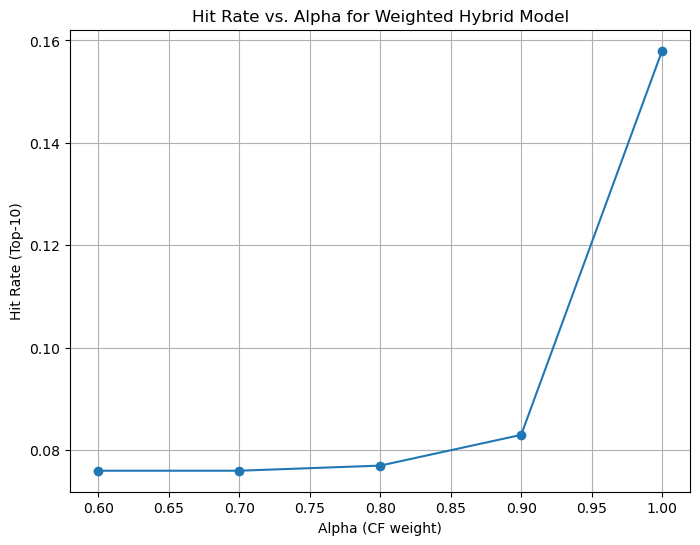

In [30]:
# Plot Hit Rate vs. Alpha
plt.figure(figsize=(8, 6))
plt.plot(alphas, hit_rates, marker='o', linestyle='-')
plt.xlabel("Alpha (CF weight)")
plt.ylabel("Hit Rate (Top-10)")
plt.title("Hit Rate vs. Alpha for Weighted Hybrid Model")
plt.grid(True)
plt.show()